## Пример задачи

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Наркоманская функция потерь, вынуждающая линейное преобразование переводить точки из многомерного пространства в двумерное на единичную окружность. Для оптимизации использовать градиентный спуск по параметрам преобразования.

Линейное преобразование точки $x$ из десятимерного пространства в точку $y$ двумерного пространства с весами преобразования $W$ и $b$:
$$y = Wx + b$$

Норма в двумерном пространстве – евклидова:
$$||y||_2 = \sqrt{y_1^2 + y_2^2}$$

Функция потерь $f_0$ штрафует расстояние от получившейся точки $y$ до единичной окружности:
$$f_0(x, W, b) = 0.5 \cdot \big| ||y||_2 - 1 \big| + \big( ||y||_2 - 1 \big)^2$$

К сожалению, оптимизация функции $f_0$ по $W$ и $b$ может быть проведена аналитически
и приводит к тривиальному решению $W = 0$, $b = (1, 0)$.
Чтобы избежать такого решения, вводим штраф на близость получившейся точки к вектору $b$, который обращается в 0, если расстояние до вектора $b$ более 1:
$$f_1(x, W, b) = \max\big(0, \frac{1}{||y - b||_2} - 1\big)$$

Итоговая функция потерь:
$$f(x, W, b) = f_0(x, W, b) + f_1(x, W, b)$$

Нужно решить следующую оптимизационную задачу:
$$\frac{1}{N}\sum\limits_{i = 1}^N f(x_i, W, b) \to \min\limits_{W, b}$$

In [20]:
def loss_f_0(z):
    distance = torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2)
    return 0.5 * torch.abs(distance - 1) + (distance - 1) ** 2

def loss_f_1(z, b):
    distance = torch.sqrt((z-b)[:,0] ** 2 + (z-b)[:,1] ** 2)
    return torch.nn.functional.relu(1/distance - 1)

def f(X, W, b):
    z = torch.matmul(X, W) + b
    loss_0, loss_1 = loss_f_0(z), loss_f_1(z, b)
    loss = loss_0 + loss_1
    return torch.mean(loss_0 + loss_1)

In [65]:
X = torch.randn(50, 10)
b = torch.randn(2)
W = torch.randn(10, 2)

tensor(12.7380)


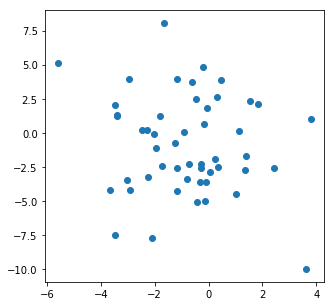

In [66]:
# Результат на случайных весах
print(f(X, W, b))
plt.figure(figsize=(5, 5))
Y = X.mm(W).add(b)
plt.scatter(Y[:, 0], Y[:, 1])

In [103]:
x_tensor = torch.tensor(X, requires_grad=True)
w_tensor = torch.tensor(W, requires_grad=True)
b_tensor = torch.tensor(b, requires_grad=True)
optimizer = torch.optim.SGD([w_tensor, b_tensor], lr=0.05, momentum=0.9)
for i in range(0,200):
    if i % 10 == 0:
        print('{}: {}'.format(i, f(x_tensor, w_tensor, b_tensor).data))
    optimizer.zero_grad()
    loss = f(x_tensor, w_tensor, b_tensor)
    loss.backward()
    optimizer.step()
print("finished")

0: 12.737998962402344
10: 3.4813077449798584
20: 36.52226257324219
30: 9.999650001525879
40: 1.9745256900787354
50: 1.1720629930496216
60: 0.875336766242981
70: 0.9066555500030518
80: 0.6306901574134827
90: 0.45122891664505005
100: 0.3626193106174469
110: 0.31948322057724
120: 0.2642340660095215
130: 0.23902525007724762
140: 0.23475965857505798
150: 0.23339225351810455
160: 0.2321547269821167
170: 0.2322722226381302
180: 0.2330823838710785
190: 0.23159746825695038
finished


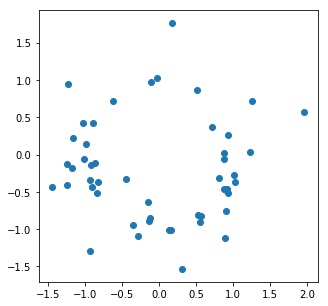

In [107]:
# Результат после обучения
plt.figure(figsize=(5, 5))
Y = X.mm(w_tensor.data).add(b_tensor.data)
plt.scatter(Y[:, 0], Y[:, 1])

# Время писать нейросеть

## Загружаем данные

In [170]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

(1797, 64) (1797,)
(1347, 64) (450, 64)


Подсказка: нейросети крайне плохо обучаются, если подаваемые им на вход значения велики по модулю.
Поэтому перед обучением нейросети каждый признак независимо нормируют
(исключение – сверточные нейросети, там нормируют изображение поканально, а не попиксельно, но об этом потом).

Можно использовать разные нормировки.
Наиболее популярно вычитать среднее и делить на дисперсию (нужно внимательно подходить к этому методу,
когда выборочная дисперсия мала или равна нулю, и обрабатывать такие случаи отдельно).
Можно также вычитать медиану и делить на интерквартильный размах, масштабировать все данные в отрезок $[-1, 1]$, etc

Нужно реализовать свою нормировку данных здесь:

In [577]:
# нормировка делением на дисперсию

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

pixel_means = torch.mean(X_train, dim=0)
#print("pixel_std: {}".format(pixel_means))
pixel_std = torch.std(X_train, dim=0)
for i in range(len(pixel_std)):
    if pixel_std[i] == 0:
        pixel_std[i] = 1
        
#print("pixel_std: {}".format(pixel_std))
X_train = (X_train - pixel_means) / pixel_std
X_test = (X_test - pixel_means) / pixel_std

(1797, 64) (1797,)
(1347, 64) (450, 64)


In [786]:
# Из коробки с помощью интерквартильного размаха
#https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

(1797, 64) (1797,)
(1347, 64) (450, 64)


## Определяем слои нейросети

In [579]:
class Module:
    def __init__(self):
        self.training = True
        self.children = []

    def forward(self, *input):
        raise NotImplementedError

    def parameters(self):
        """Returns list of parameters of module and its children."""
        res = []
        for submodule in self.children:
            res += submodule.parameters()
        for param in res:
            if not isinstance(param, torch.Tensor):
                raise Exception('Parameters must be Tensors.')
        return res
    
    def zero_grad(self):
        """Sets gradients of all model parameters to zero."""
        for p in self.parameters():
            if p.grad is not None:
                p.grad.detach_()   # detachs gradient Tensor from the computational graph
                p.grad.zero_()

    def train(self):
        """Sets module into train mode (for DropOut, BatchNorm, etc)."""
        self.training = True
        for submodule in self.children:
            submodule.train()

    def eval(self):
        """Sets module into evaluation mode."""
        self.training = False
        for submodule in self.children:
            submodule.eval()

In [581]:
class Dense(Module):
    def __init__(self, input_units, output_units):
        """A dense layer is a layer which performs a learned affine transformation:
        f(x) = W x + b
        """
        super(Dense, self).__init__()
        # initialize weights with small random numbers from normal distribution
        self.weights = torch.empty(input_units, output_units, dtype=torch.float).normal_(mean=0, std=1)  # your code here
        self.weights = torch.tensor(self.weights, requires_grad=True)
        
        self.biases = torch.empty(output_units, dtype=torch.float).normal_(mean=0, std=1)   # your code here
        self.biases = torch.tensor(self.biases, requires_grad=True)
        
    def parameters(self):
        return [self.weights, self.biases]
        
    def forward(self, input):
        """Performs an affine transformation:
        f(x) = W x + b
        input shape:  [batch, input_units]  (Tensor)
        output shape: [batch, output units] (Tensor)
        """
        # your code here
        output = input.mm(self.weights).add(self.biases)
        
        return output

In [790]:
class ReLU(Module):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs."""
        super(ReLU, self).__init__()

    def parameters(self):
        return []  # ReLU has no parameters
    
    def forward(self, input):
        """Applies elementwise ReLU to [batch, num_units] Tensor matrix."""
        # your code here
        output = torch.max(input, torch.zeros_like(input))
        return output

In [999]:
import torch.nn.functional as F
class LogSoftmax(Module):
    def __init__(self):
        super(LogSoftmax, self).__init__()

    def parameters(self):
        return []
        
    def forward(self, input):
        """Applies softmax to each row and then applies component-wise log.
        Input shape:  [batch, num_units] (Tensor)
        Output shape: [batch, num_units] (Tensor)
        """
        # your code here
        #output = input.data.numpy()
        #output = output - np.max(output, axis=1)[:, np.newaxis] 
        #output = np.log(np.exp(output) / np.sum(np.exp(output), axis=1)[:, np.newaxis])
        #return output
        
        # ^Не получилось сделать чисто на torch переменных функцию, только np и в ней не работали бы фичи из торча
        # решил выпилить и вставить готовую
        output = F.log_softmax(input, dim=1)
        return output

In [1000]:
class MyNetwork(Module):
    def __init__(self, input_size, hidden_layers_size, hidden_layers_number, output_size):
        super(MyNetwork, self).__init__()

        network = []
        network.append(Dense(input_size, hidden_layers_size))
        network.append(ReLU())
        for i in range(hidden_layers_number - 1):
            network.append(Dense(hidden_layers_size, hidden_layers_size))
            network.append(ReLU())
        network.append(Dense(hidden_layers_size, output_size))
        network.append(LogSoftmax())

        self.children = network

    def forward(self, input):
        """Applies all layers of neural network to the input.
        Input shape:  [batch, num_units] (Tensor)
        Output shape: [batch, num_units] (Tensor)
        """
        output = input
        # your code here
        for layer in self.children:
            output = layer.forward(output)
        return output

In [1001]:
network = MyNetwork(X_train.shape[1], 32, 1, 10)

## Определяем функцию потерь

In [1002]:
def crossentropy(activations, target):
    return -1*torch.mean(activations*torch.Tensor(torch.eye(activations.shape[1])[target.data]))

## Оптимизатор SGD

In [1003]:
class SGDOptimizer:
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        """Make one optimization step for parameters in-place.
        Assumes that all parameters are Variable with computed gradient.
        """
        for param in self.parameters:
            param.data -= self.learning_rate * param.grad.data

In [1004]:
import torch.utils.data

In [1005]:
def run_epoch(dataset, network, prefix='Test loss:', optimizer=None):
    # Change mode for all layers.
    if optimizer:
        network.train()
    else:
        network.eval()

    batch_size = 100
    batchgenerator = torch.utils.data.DataLoader(dataset, batch_size, True)

    avg_loss = 0
    for i, (batch_data, batch_target) in enumerate(batchgenerator):
        batch_output = network.forward(torch.tensor(batch_data))
        batch_loss = crossentropy(batch_output, torch.tensor(batch_target))
        batch_loss.backward()
        batch_loss = batch_loss.data.numpy()
        avg_loss += (batch_loss - avg_loss) / (i + 1)
        if optimizer:
            optimizer.step()
            network.zero_grad()
    print(prefix, avg_loss, flush=True)

In [1006]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

network = MyNetwork(X_train.shape[1], 32, 1, 10)
sgd = SGDOptimizer(network.parameters(), 0.5)

num_epochs = 20
for i in range(num_epochs):
    run_epoch(train_dataset, network, 'Train loss:', sgd)
    run_epoch(test_dataset, network, 'Test loss:',  None)

Train loss: 1.3224943748542242
Test loss: 0.7270618915557862
Train loss: 0.5076459433351245
Test loss: 0.36908066272735596
Train loss: 0.301526950938361
Test loss: 0.2610673666000366
Train loss: 0.21695233987910406
Test loss: 0.20664595067501068
Train loss: 0.17594877311161589
Test loss: 0.1719949334859848
Train loss: 0.1476305526282106
Test loss: 0.1453218162059784
Train loss: 0.12818284811718123
Test loss: 0.12881805151700973
Train loss: 0.11138748058250972
Test loss: 0.10774884819984436
Train loss: 0.10098956472107343
Test loss: 0.10085771232843399
Train loss: 0.09135710022279195
Test loss: 0.09121232479810715
Train loss: 0.08511429013950483
Test loss: 0.08060893416404724
Train loss: 0.07742203399538994
Test loss: 0.07724456787109375
Train loss: 0.07352124713361265
Test loss: 0.07183605208992958
Train loss: 0.0661870211895023
Test loss: 0.06559795588254928
Train loss: 0.06419315401996883
Test loss: 0.05996919944882393
Train loss: 0.06047454449747291
Test loss: 0.05795879513025284
Tr

## Больше оптимизаторов Б-гу Оптимизации!

In [1007]:
class SGDMomentumOptimizer:
    def __init__(self, parameters, learning_rate=0.01, momentum=0.9):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        # your code here
        self.rates = [torch.zeros_like(x) for x in self.parameters]

    def step(self):
        """Make one optimization step for parameters in-place.
        Assumes that all parameters are Variable with computed gradient.
        """
        # your code here
        for ix in range(len(self.parameters)):
            self.rates[ix] = - 1 * self.learning_rate * self.parameters[ix].grad.numpy() + self.momentum * self.rates[ix] 
            self.parameters[ix].data = self.parameters[ix].data + self.rates[ix]

In [1008]:
class RMSPropOptimizer:
    def __init__(self, parameters, learning_rate=0.01, beta=0.9, eps=1e-8):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.eps = eps
        # your code here
        self.running_averages = [torch.zeros_like(x) for x in self.parameters]

    def step(self):
        """Make one optimization step for parameters in-place.
        Assumes that all parameters are Variable with computed gradient.
        """
        # your code here
        for ix in range(len(self.parameters)):
            self.running_averages[ix] = self.beta * self.running_averages[ix] + (1-self.beta) * (self.parameters[ix].grad.data**2)
            self.parameters[ix].data = self.parameters[ix].data - self.learning_rate/torch.sqrt(self.eps+self.running_averages[ix]) * self.parameters[ix].grad.data

In [1009]:
class AdamOptimizer:
    def __init__(self, parameters, learning_rate=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        # your code here
        
        self.m = [torch.zeros_like(x) for x in self.parameters]
        self.v = [torch.zeros_like(x) for x in self.parameters]
        
    def step(self):
        """Make one optimization step for parameters in-place.
        Assumes that all parameters are Variable with computed gradient.
        """
        # your code here
                    
        for ix in range(len(self.parameters)):
            self.m[ix] = (self.beta1 * self.m[ix] + (1-self.beta1)*self.parameters[ix].grad.data)
            self.v[ix] = (self.beta2 * self.v[ix] + (1-self.beta2)*self.parameters[ix].grad.data**2)
            
            m, v = self.m[ix] / (1-self.beta1), self.v[ix] / (1-self.beta2)
            self.parameters[ix].data = self.parameters[ix].data - self.learning_rate * m / (torch.sqrt(v) + self.eps)

In [1010]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [1011]:
network = MyNetwork(X_train.shape[1], 32, 1, 10)
optim = SGDMomentumOptimizer(network.parameters(), 0.5)

num_epochs = 20
for i in range(num_epochs):
    run_epoch(train_dataset, network, 'Train loss:', optim)
    run_epoch(test_dataset, network, 'Test loss:',  None)

Train loss: 0.8861593838248935
Test loss: 0.20479665398597718
Train loss: 0.17421326573405946
Test loss: 0.14796899855136872
Train loss: 0.12490521584238323
Test loss: 0.10206914991140366
Train loss: 0.0837956563170467
Test loss: 0.07655073627829552
Train loss: 0.06571268662810326
Test loss: 0.05869651436805725
Train loss: 0.052306749458823895
Test loss: 0.04741026982665062
Train loss: 0.046197399363986084
Test loss: 0.04226075559854507
Train loss: 0.039615299486156025
Test loss: 0.03747780472040176
Train loss: 0.03563952765294484
Test loss: 0.03190916888415814
Train loss: 0.03253141351576362
Test loss: 0.028747232630848885
Train loss: 0.029644607965435298
Test loss: 0.028675852715969084
Train loss: 0.02776321349665523
Test loss: 0.026266885921359062
Train loss: 0.02516721681292568
Test loss: 0.02386121600866318
Train loss: 0.024048338777252605
Test loss: 0.021739119291305543
Train loss: 0.022381451513086046
Test loss: 0.019869045168161393
Train loss: 0.022064340699996264
Test loss: 0.

In [1012]:
network = MyNetwork(X_train.shape[1], 32, 1, 10)
optim = RMSPropOptimizer(network.parameters())

num_epochs = 20
for i in range(num_epochs):
    run_epoch(train_dataset, network, 'Train loss:', optim)
    run_epoch(test_dataset, network, 'Test loss:',  None)

Train loss: 0.9974486018930161
Test loss: 0.48690699934959414
Train loss: 0.3242223784327507
Test loss: 0.2738447844982147
Train loss: 0.2037073490875108
Test loss: 0.18880587220191955
Train loss: 0.13974261709621974
Test loss: 0.13339255899190902
Train loss: 0.10189123983894077
Test loss: 0.09618145674467087
Train loss: 0.07282346008079392
Test loss: 0.0762104794383049
Train loss: 0.057651125958987644
Test loss: 0.06216159537434578
Train loss: 0.043891087906169045
Test loss: 0.05350874662399292
Train loss: 0.03454694970111762
Test loss: 0.03845533058047294
Train loss: 0.03007998038083315
Test loss: 0.040523811429739
Train loss: 0.02542869267719133
Test loss: 0.030320070497691632
Train loss: 0.021569779941013882
Test loss: 0.02578662596642971
Train loss: 0.021035370150847096
Test loss: 0.021347801387310027
Train loss: 0.0164237154780754
Test loss: 0.027851981483399867
Train loss: 0.016127016860991716
Test loss: 0.01899546030908823
Train loss: 0.012630351519744313
Test loss: 0.016489765

In [1013]:
network = MyNetwork(X_train.shape[1], 32, 1, 10)
optim = AdamOptimizer(network.parameters())

num_epochs = 20
for i in range(num_epochs):
    run_epoch(train_dataset, network, 'Train loss:', optim)
    run_epoch(test_dataset, network, 'Test loss:',  None)

Train loss: 1.5308962932654788
Test loss: 0.6812158226966858
Train loss: 0.39744293051106594
Test loss: 0.2385811150074005
Train loss: 0.1660539640911988
Test loss: 0.1477382645010948
Train loss: 0.1085784448576825
Test loss: 0.10334560424089431
Train loss: 0.08135044388473034
Test loss: 0.07799172103404999
Train loss: 0.06676233054271766
Test loss: 0.06133635714650154
Train loss: 0.05689226569873946
Test loss: 0.049878443405032155
Train loss: 0.05074265213417155
Test loss: 0.04375402368605137
Train loss: 0.046708913653024604
Test loss: 0.03705931566655636
Train loss: 0.04094179879341806
Test loss: 0.03237900622189045
Train loss: 0.03793670862380948
Test loss: 0.031139878556132317
Train loss: 0.036193248350173235
Test loss: 0.027106764167547225
Train loss: 0.032818896363356276
Test loss: 0.025554902851581573
Train loss: 0.02961194328963756
Test loss: 0.022148158773779868
Train loss: 0.029320692710046253
Test loss: 0.0201693594455719
Train loss: 0.027039149975670237
Test loss: 0.0208058

## Эксперименты с DropOut

Этот пункт обязателен к выполнению.
Для того, чтобы получить бонусный балл за этот пункт, нужно эффективно реализовать DropOut:
не вычислять активации выкинутых нейронов, прежде чем их обнулить.

In [1201]:
class DenseWithDropOut(Module):
    def __init__(self, input_units, output_units, dropout_rate, nonlinearity):
        """A dense layer is a layer which performs a learned
        affine transformation and applies dropout:
        m ~ Bernoulli(1 - p, size=output_units)
        f(x) = g(W x + b) o m
        """
        super(DenseWithDropOut, self).__init__()
        self.dropout_rate = dropout_rate
        self.nonlinearity = nonlinearity
        # initialize weights with small random numbers from normal distribution
        self.weights = torch.empty(input_units, output_units, dtype=torch.float).normal_(mean=0, std=1)  # your code here
        self.weights = torch.tensor(self.weights, requires_grad=True)
        
        self.biases = torch.empty(output_units, dtype=torch.float).normal_(mean=0, std=1)   # your code here
        self.biases = torch.tensor(self.biases, requires_grad=True)

    def parameters(self):
        return [self.weights, self.biases]
        
    def forward(self, input):
        """Performs an affine transformation with dropout.
        In training mode:
        m ~ Bernoulli(1 - p, size=output_units)
        f(x) = g(W x + b) o m
        In evaluation mode:
        f(x) = g(W x + b) (1 - p)
        input shape:  [batch, input_units]  (Variable)
        output shape: [batch, output units] (Variable)
        """
        # your code here        
        if self.training:
            m = torch.empty(self.weights.shape[1]).bernoulli_(1.0-self.dropout_rate)
            nonzero_indices = m.nonzero().squeeze().long()
            if nonzero_indices.shape and nonzero_indices.shape[0] > 0:
                output = self.nonlinearity((input[nonzero_indices]).t().mm(self.weights[nonzero_indices]).add(self.biases))
            else:
                output = self.nonlinearity(input.mm(self.weights).add(self.biases))
                
            # Не сработает - тк все равно нужно будет ходить по всем элементам
            # return output = self.nonlinearity(input.mm(self.weights).add(self.biases)) * m
        else:
            output = (1 - self.dropout_rate) * self.nonlinearity(input.mm(self.weights).add(self.biases))
        
        return output

Проверяем, верно ли, что полносвязная сеть с dropout работает быстрее, чем обычная полносвязная сеть, поскольку на каждом проходе вычисляются произведения матриц меньшего размера.

In [ ]:
width = 2000
network1 = [
    DenseWithDropOut(width, width, 0.9, lambda x: ReLU().forward(x)),
    DenseWithDropOut(width, width, 0.9, lambda x: ReLU().forward(x)),
    DenseWithDropOut(width, width, 0.9, lambda x: ReLU().forward(x)),
    DenseWithDropOut(width, 1, 0, lambda x: x)
]
network2 = [
    Dense(width, width),
    ReLU(),
    Dense(width, width),
    ReLU(),
    Dense(width, width),
    ReLU(),
    Dense(width, 1)
]
X = torch.randn(10000, width)

# check whether DenseWithDropOut works faster than Dense
def test_network(network):
    x = torch.tensor(X)
    for layer in network:
        x = layer.forward(x)
    x.mean().backward()
    for layer in network:
        x = layer.zero_grad()

test_network(network1)
print("DenseWithDropOut:")
%timeit test_network(network1)
print("Dense:")
%timeit test_network(network2)

DenseWithDropOut:
355 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dense:


Для более узких слоев, меньших dropout rate и меньших размеров батча увеличение производительности не настолько существенно или может вообще отсутствовать.